In [18]:
import csv
import re
import os 
import sys
import pickle
import pandas as pd
import gensim
from gensim import corpora
from collections import Counter

working_dir = '/users/sbuongiorno/'
n_topics = 100

In [19]:
fname = '/scratch/group/pract-txt-mine/sbuongiorno/hansard_decades/hansard_1800.csv'

with open(fname, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)[1:]
    data = list(map(str, data))

data[:2]

["['S1V0001P0_0', 'moved that Lord Walsingham be appointed chairman of the committee of privileges for the present session.']",
 '[\'S1V0001P0_11\', "The subject, in his contemplation, was such as not only that house, but many thousands of his Majesty\'s subjects must regard with the utmost concern."]']

In [20]:
data = [re.sub(r'\b[A-Z]+(?:\s+[A-Z]+)*\b', '', ls) for ls in data] # remove words that are all upper case - so names 
data = [re.sub(r'\\\\n|\\\\t|\'s', '', ls) for ls in data] # remove lien breaks, tab breaks, and possessive "s"
data = [re.sub(r'[^\w\s]|_', '', ls) for ls in data] # remove punctuation and underscore
data = [re.sub(r'\d{1, 3}', '', ls) for ls in data] # remove digits that are a minimum of 1 and a maximum of 3
data = [re.sub(r'\w*\d\w*', '', ls) for ls in data] # remove character strings that contain a digit
            
data = [word.lower() for word in data]
    
data = [ls.split() for ls in data]

In [21]:
data[:2]
#data = data[:15]

In [22]:
dictionary = corpora.Dictionary(data)

dictionary

In [23]:
corpus = [dictionary.doc2bow(text) for text in data]

corpus[:2]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 1)],
 [(7, 1),
  (11, 1),
  (12, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 2),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1)]]

In [24]:
%%time

lda_model = gensim.models.LdaMulticore(corpus, num_topics = n_topics, id2word=dictionary, workers = 4, passes=15)

CPU times: user 826 ms, sys: 206 ms, total: 1.03 s
Wall time: 986 ms


## Saving

In [22]:
working_folder = working_dir + 'lda_topic_model_test/'

if not os.path.exists(working_folder):
    os.mkdir(working_folder)

In [23]:
pickle.dump(corpus, open(working_folder + 'corpus.pkl', 'wb'))
dictionary.save(working_folder + 'dictionary.gensim')
lda_model.save(working_folder + 'model.gensim')

## Loading

In [24]:
corpus = pickle.load(open(working_folder +  'corpus.pkl', 'rb'))
dictionary = gensim.corpora.Dictionary.load(working_folder + 'dictionary.gensim')
lda_model = gensim.models.ldamodel.LdaModel.load(working_folder + 'model.gensim')

In [25]:
lda_model.show_topics(formatted=False, num_topics = 5)

[(54,
  [('experience', 0.005813954),
   ('individuals', 0.005813954),
   ('necessity', 0.005813954),
   ('other', 0.005813954),
   ('particularly', 0.005813954),
   ('pursuing', 0.005813954),
   ('reenactment', 0.005813954),
   ('when', 0.005813954),
   ('exercised', 0.005813954),
   ('felt', 0.005813954)]),
 (32,
  [('experience', 0.005813954),
   ('individuals', 0.005813954),
   ('necessity', 0.005813954),
   ('other', 0.005813954),
   ('particularly', 0.005813954),
   ('pursuing', 0.005813954),
   ('reenactment', 0.005813954),
   ('when', 0.005813954),
   ('exercised', 0.005813954),
   ('felt', 0.005813954)]),
 (31,
  [('experience', 0.005813954),
   ('individuals', 0.005813954),
   ('necessity', 0.005813954),
   ('other', 0.005813954),
   ('particularly', 0.005813954),
   ('pursuing', 0.005813954),
   ('reenactment', 0.005813954),
   ('when', 0.005813954),
   ('exercised', 0.005813954),
   ('felt', 0.005813954)]),
 (34,
  [('experience', 0.005813954),
   ('individuals', 0.00581395

In [26]:
topics = lda_model.show_topics(formatted=False, num_topics = 100)
            
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)
            
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
df.to_csv(working_dir + 'topics_' + str(n_topics) + '.csv')

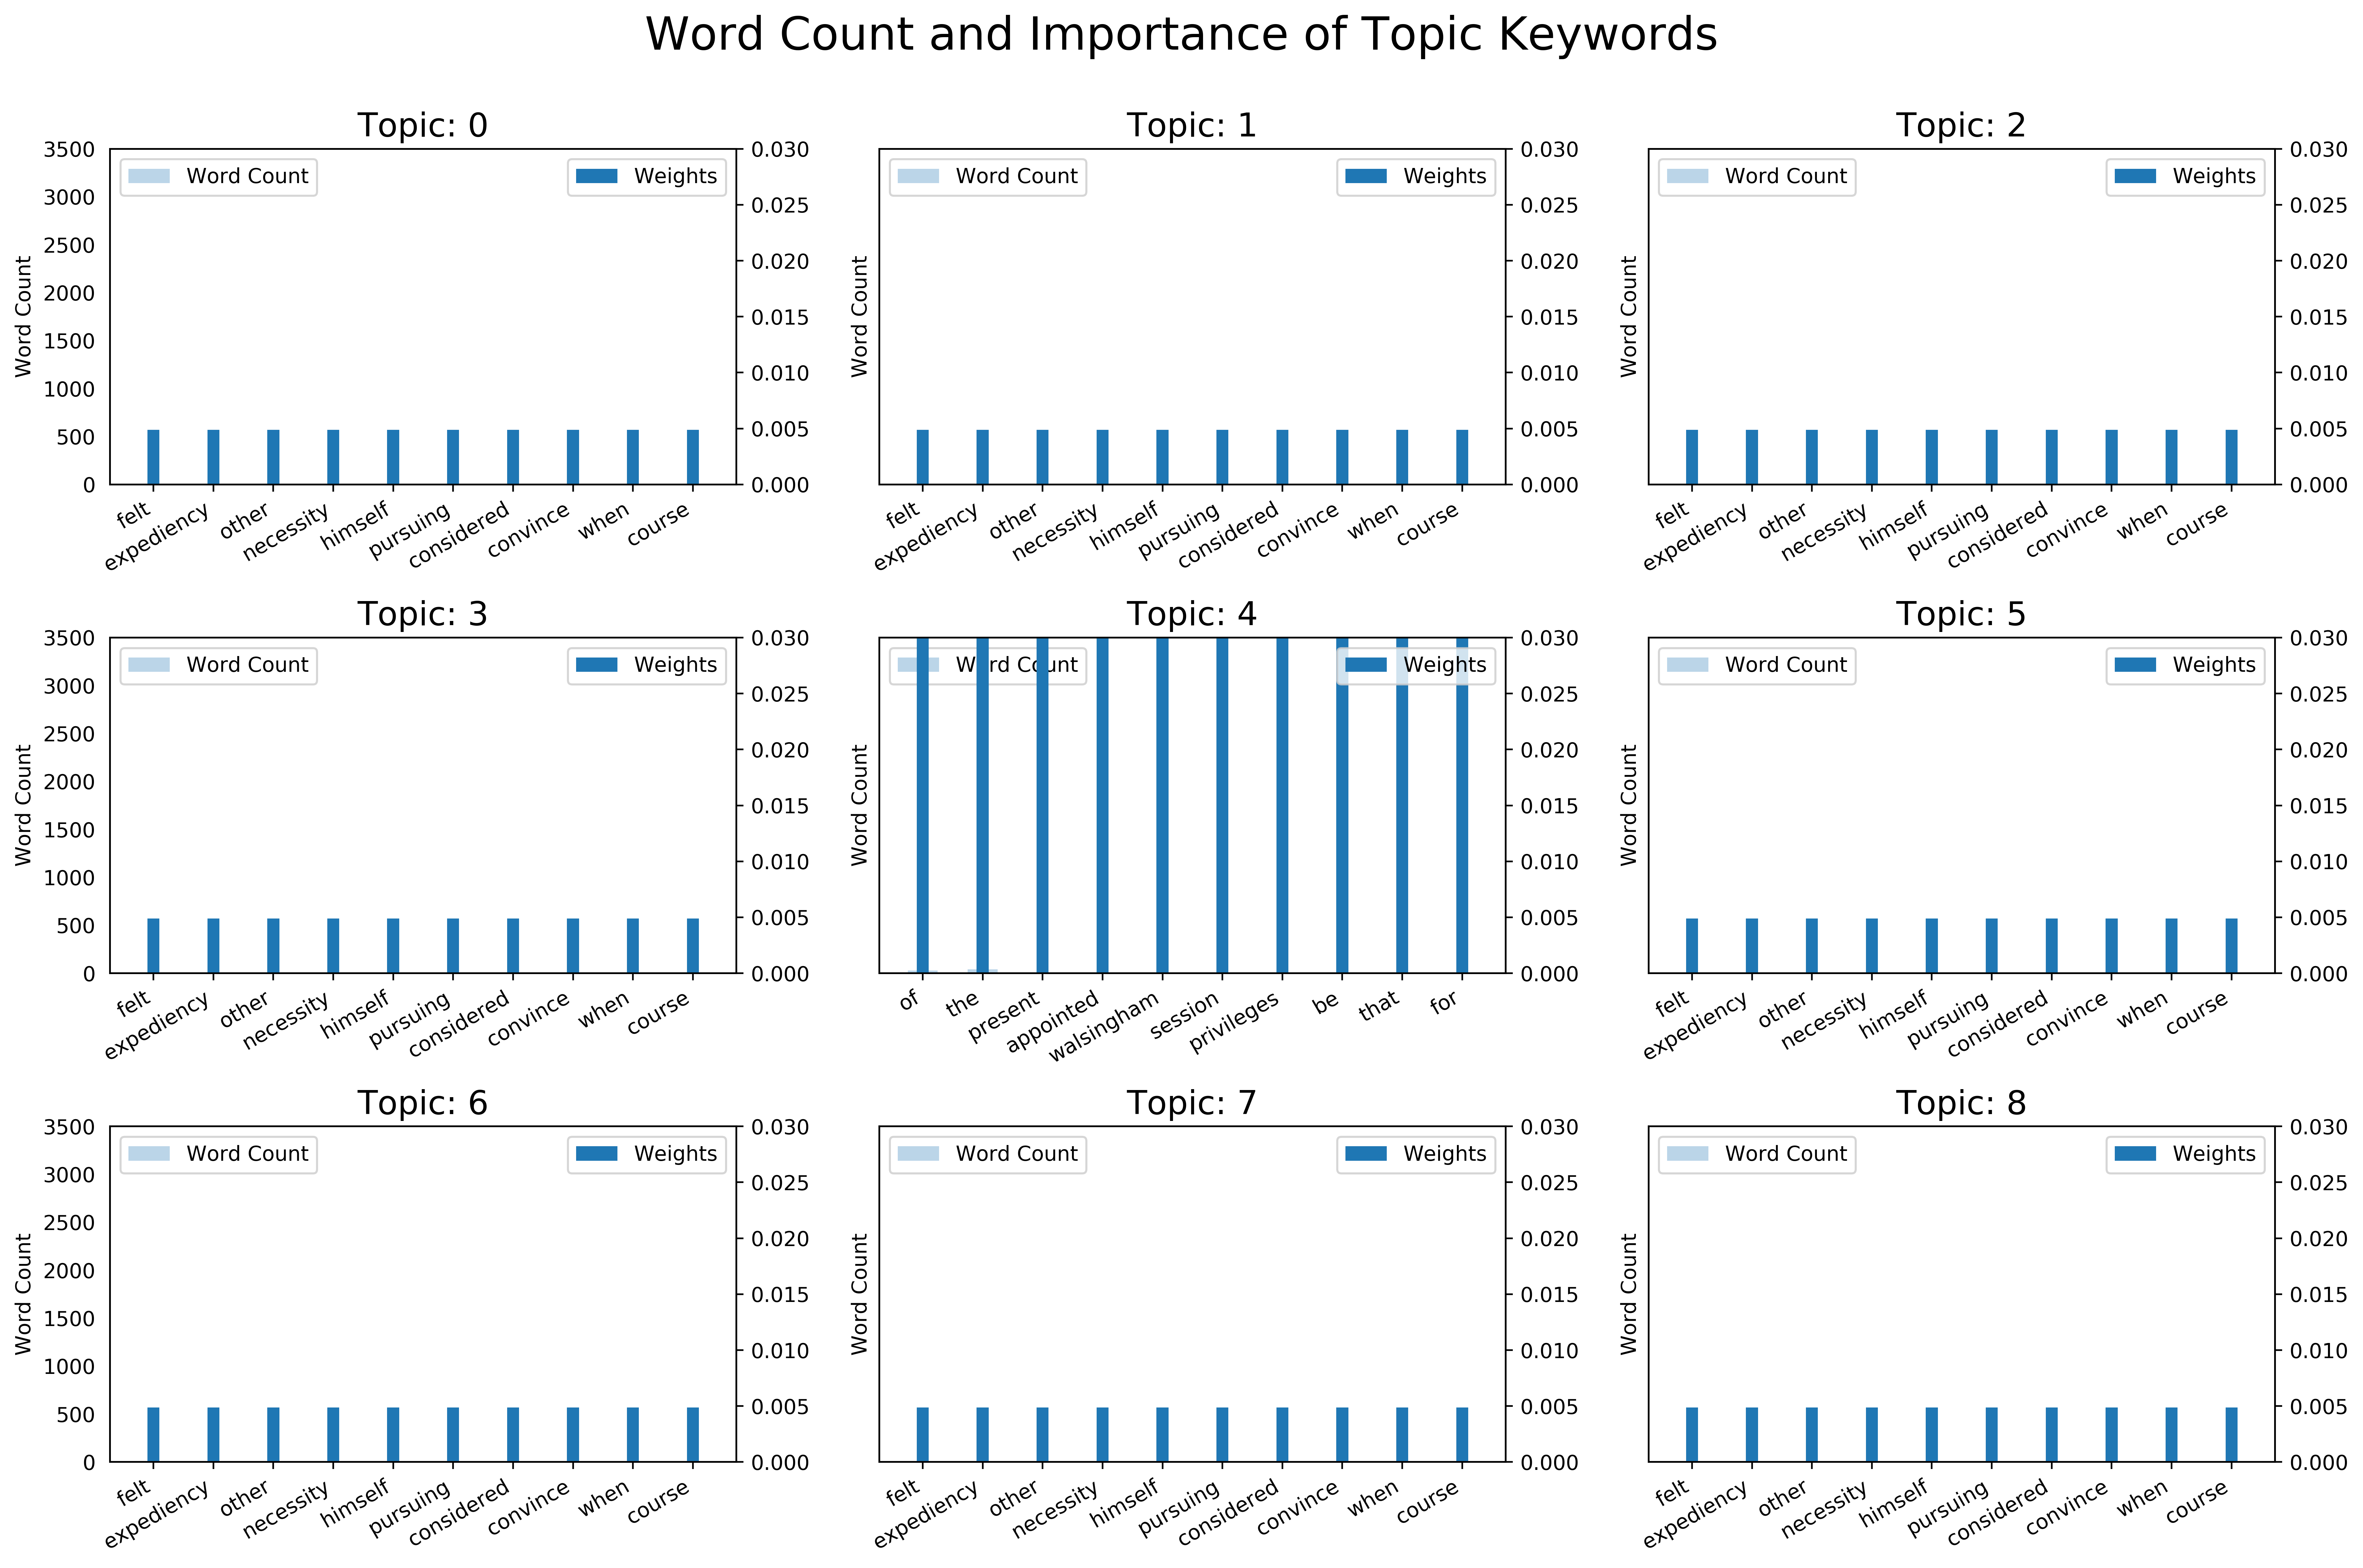

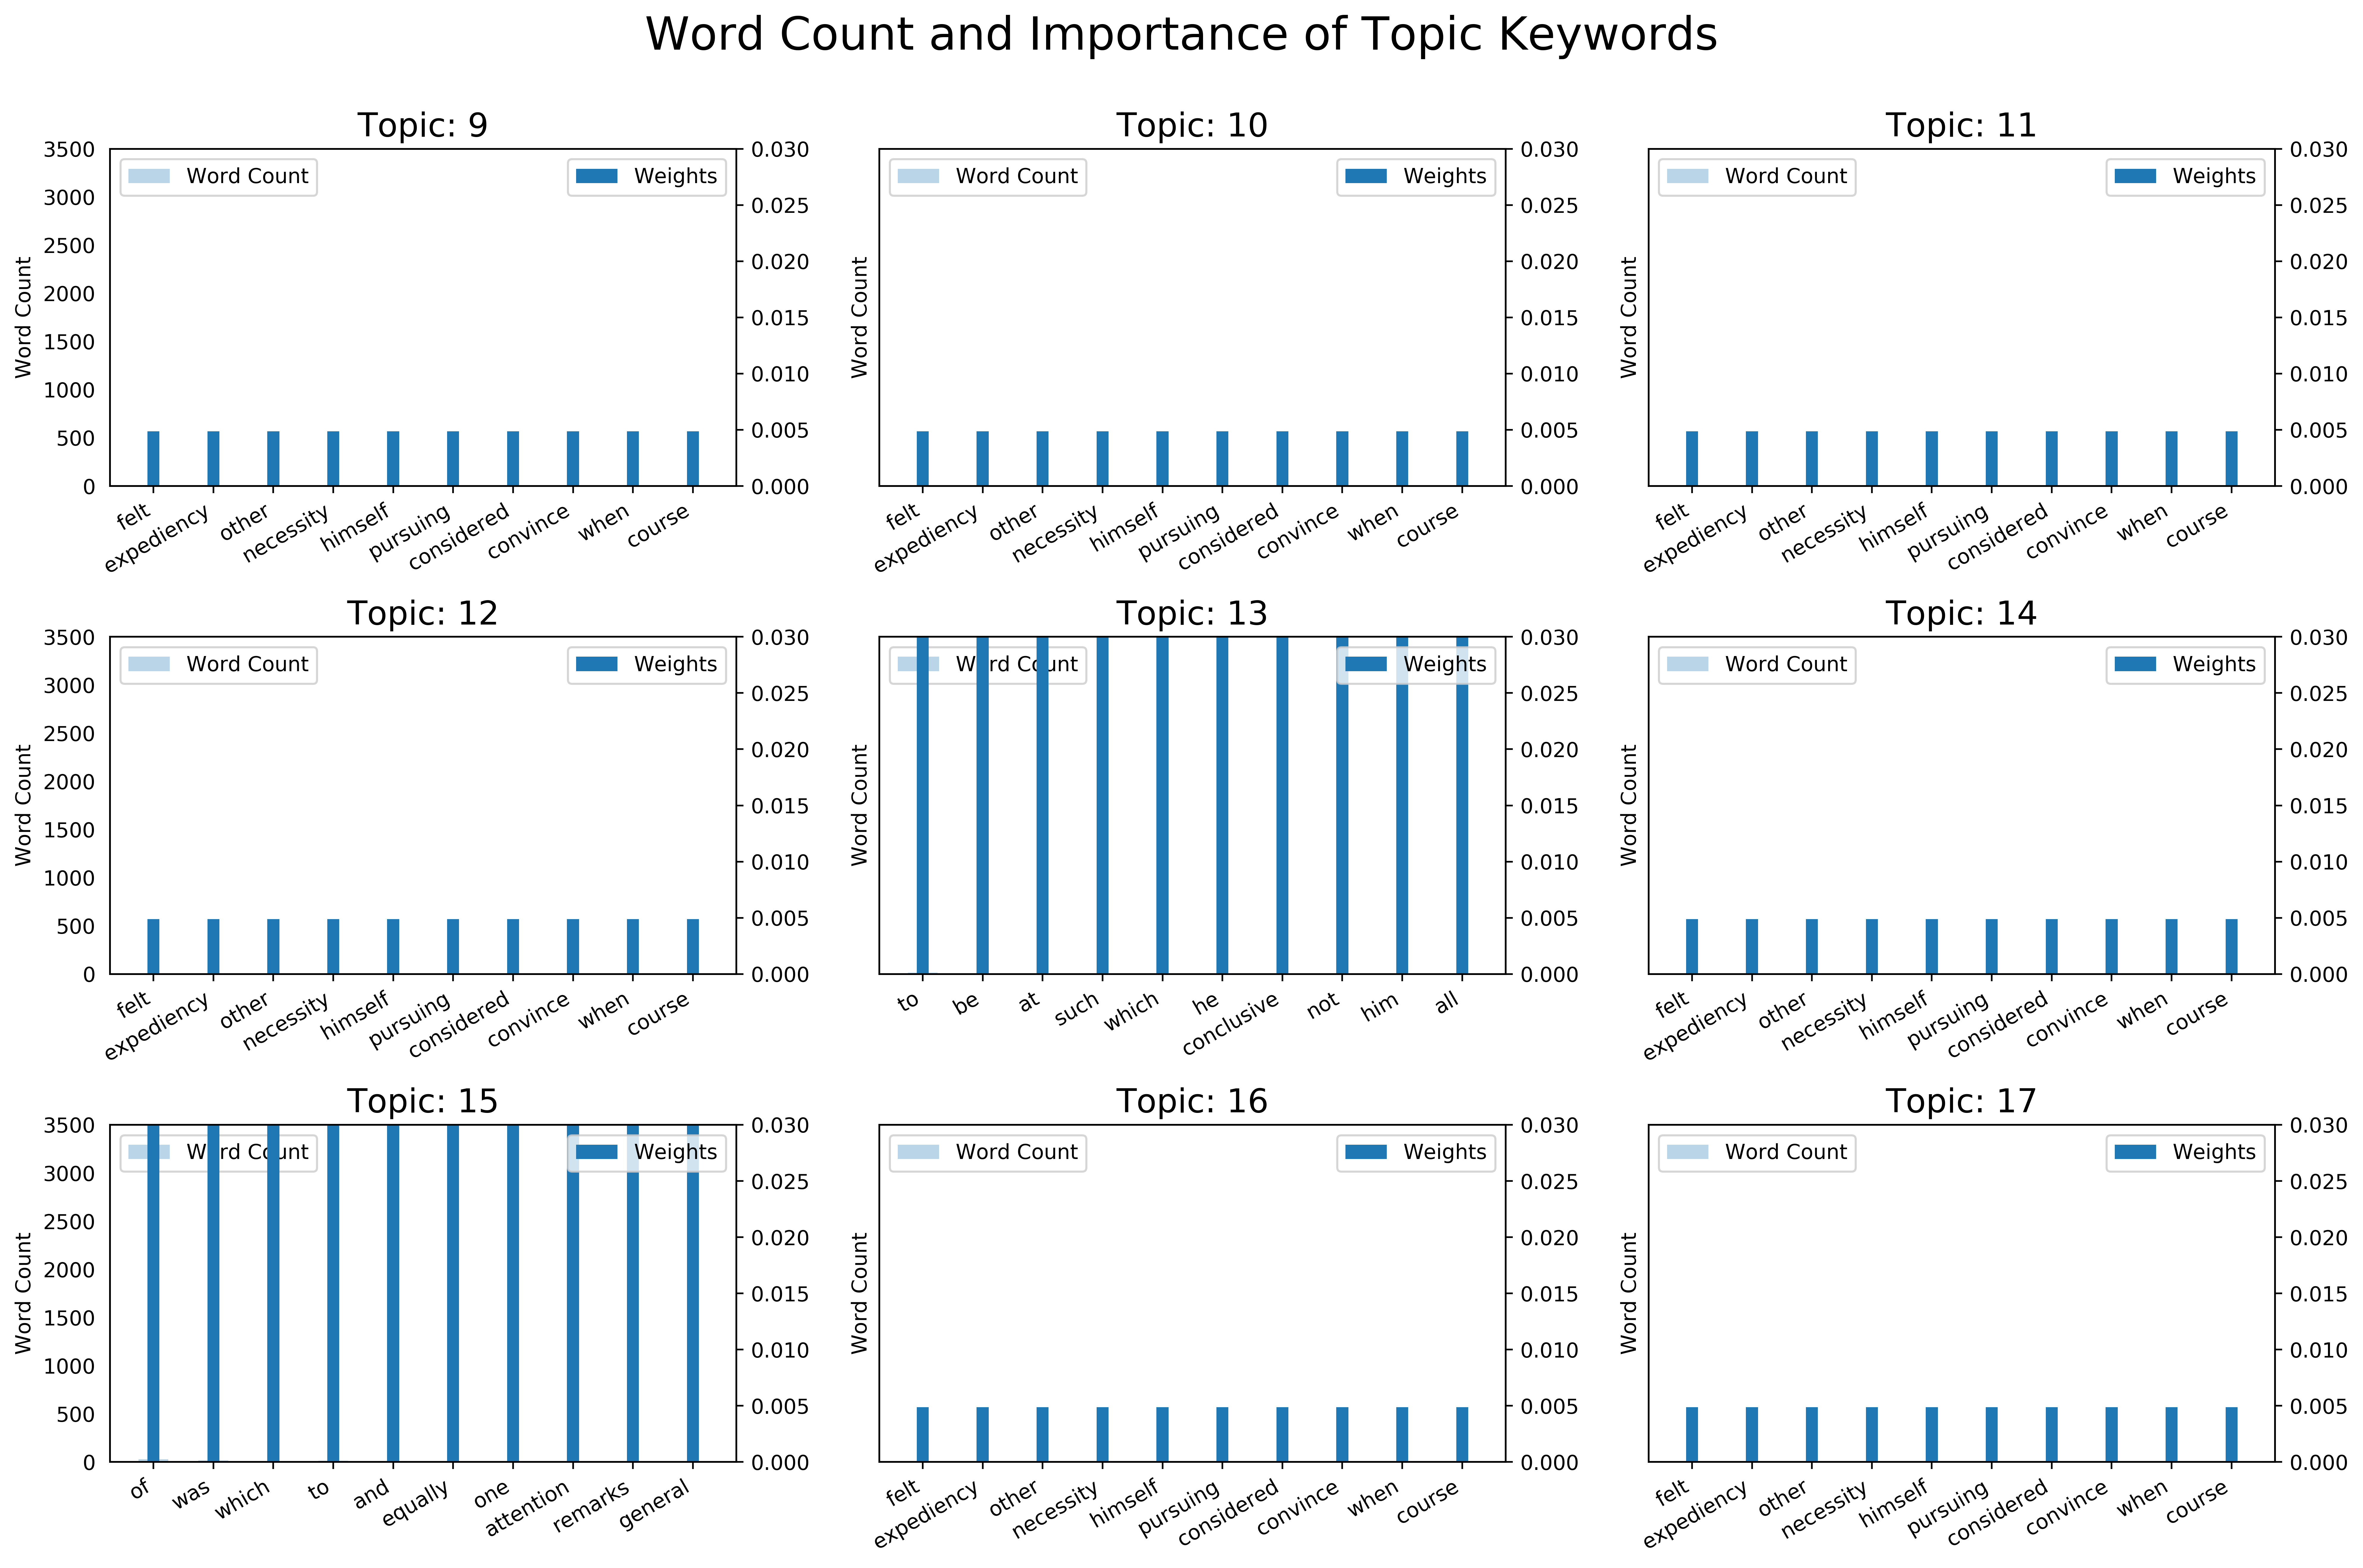

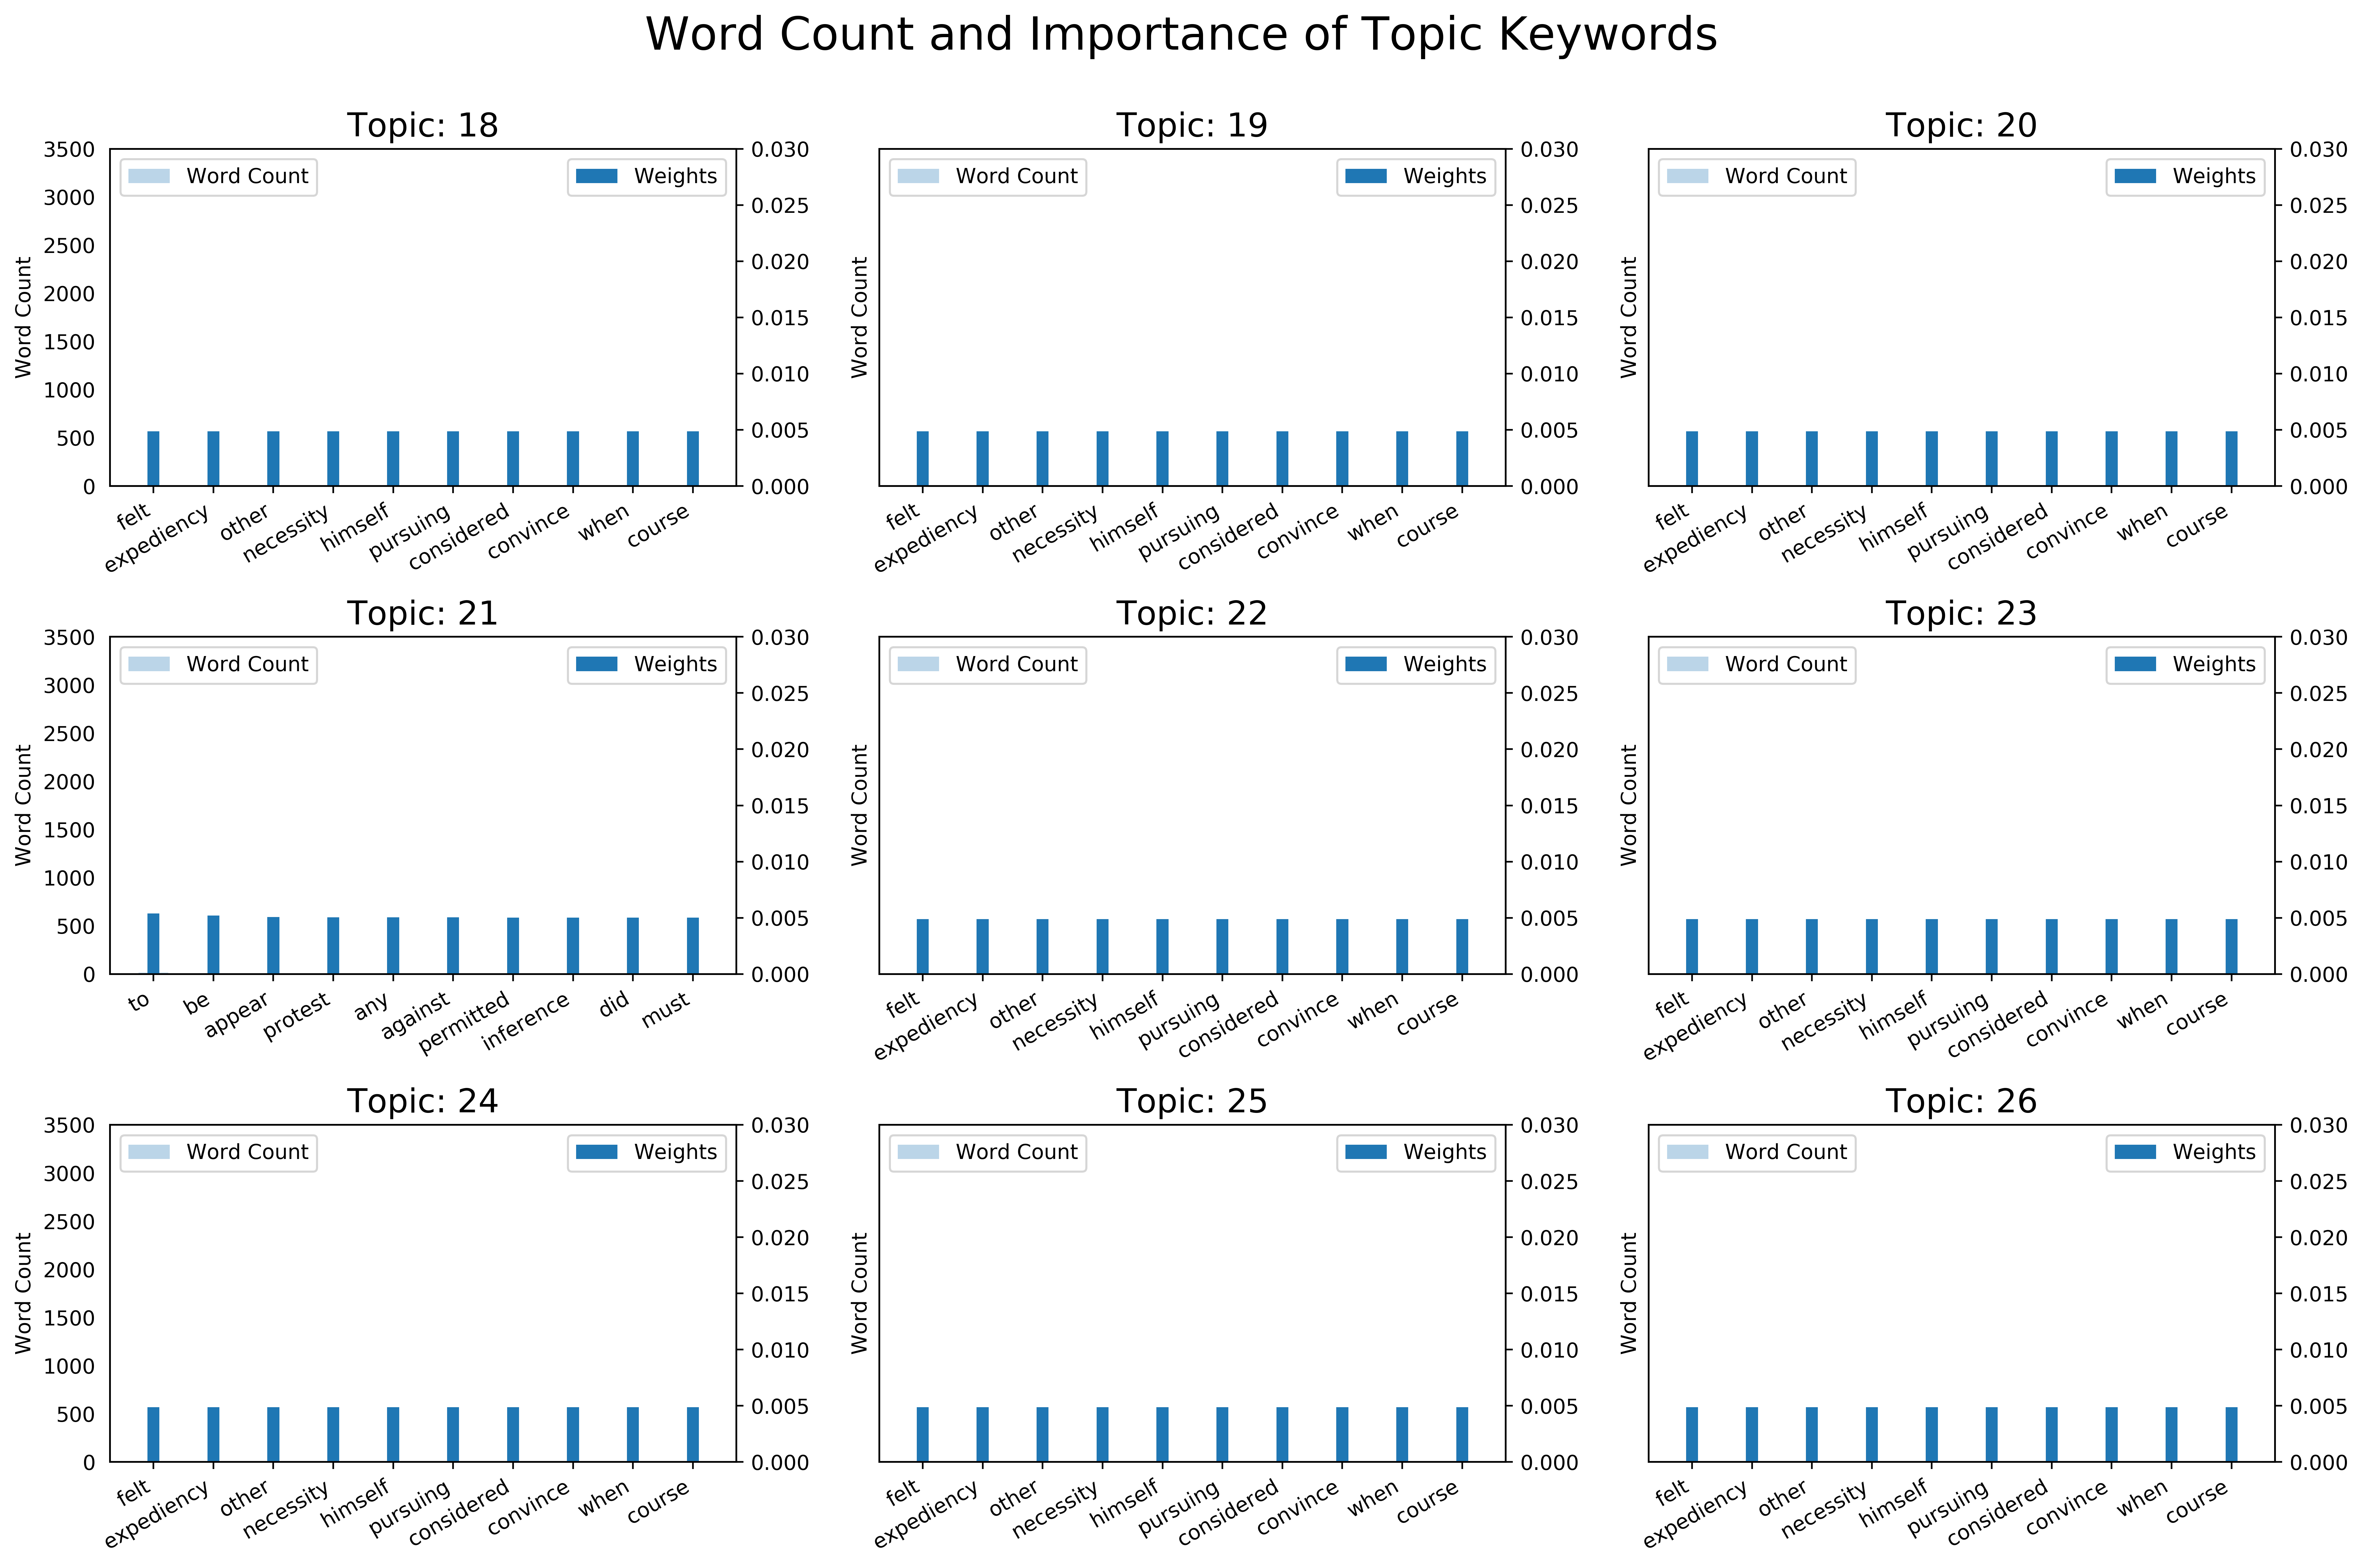

In [32]:
from matplotlib import pyplot as plt

start = -9
stop = 0

for t in range(0,3):
    start = start + 9
    stop = stop + 8

    fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=500)
    #cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        i = i + start 

        #ax.set_facecolor('white')

        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :],  width=0.5, alpha=0.3, label='Word Count') #color=cols[i],
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :],  width=0.2, label='Weights') # color=cols[i],
        ax.set_ylabel('Word Count')#, color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), fontsize=16) # color=cols[i], 
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()

    #viz_export_folder = dir + '/' + 'lda_topic_model_visualizations_' + target_folder + '/'

    #if not os.path.exists(viz_export_folder):
    #        os.mkdir(viz_export_folder)

    #plt.savefig(viz_export_folder + target_folder + '_topics_' + str(start) + '-' + str(stop) + '.jpg')
    #plt.close(fig) 

In [ ]:
#def import_stopwords(): # read stop words as list of strings
#    with open(path + 'topic-modeling/stopwords.csv') as f:
#        stopwords = f.read().splitlines()[1:]
            
#    stopwords = re.compile('|'.join(stopwords))

#    return stopwords
# stopwords = topic_model.import_stopwords()

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size = 300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict = dict(size = 16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()